# Microgrid with PV, battery and a dispatchable generator

Demo of main data structures and functions of [Microgrids.py](https://github.com/Microgrids-X/Microgrids.py).
Main steps are:

1. Describe the Microgrid project and components
2. Simulation the Microgrid
3. Analyze simulation results (technical and economic)

Also, at the end of this notebook, there is an interactive simulation using [ipywidgets](https://ipywidgets.readthedocs.io).

In [1]:
try: # Install microgrids package in JupyterLite (if run in JupyterLite)
    import piplite
    await piplite.install(['microgrids', 'ipywidgets'])
except ImportError:
    pass

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import microgrids as mgs

## Load time series data

Read load and solar data:
- Load: real consumption data at an hourly timestep from the [Ushant island](https://en.wikipedia.org/wiki/Ushant) in 2016
- Solar data comes from [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html). See [data/SOURCES.md](data/SOURCES.md).

Remarks:
- do not hesitate to use *your own data file(s)*. You need two vectors of 24×365 = 8760 points.
- if you run this notebook from JupyterLite (i.e. the demo embedded in a web page), you can upload a data file from the [file browser](https://jupyterlab.readthedocs.io/en/stable/user/files.html) in the left sidebar.

In [3]:
from pathlib import Path
folder = Path('.')
datapath = folder / 'data' / 'Ouessant_data_2016.csv'

In [4]:
data = np.loadtxt(datapath, delimiter=',', skiprows=2, usecols=(1,2))

# Split load and solar data:
Pload = data[:,0] # kW
Ppv1k =  data[:,1] / 1000; # convert to kW/kWp

Display load data

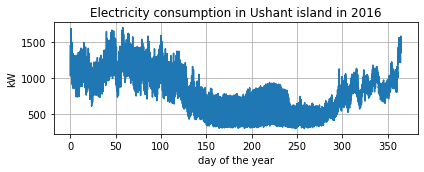

In [5]:
fig, ax = plt.subplots(1,1, figsize=(6,2.5))

td = np.arange(len(Pload))/24 # time in days
ax.plot(td, Pload, label="load")

ax.grid(True)
ax.set(
    title='Electricity consumption in Ushant island in 2016',
    ylabel='kW',
    xlabel='day of the year'
);
fig.tight_layout()
plt.show()

## Microgrid description

Describe the Microgrid project and its components in data structure

### Project parameters

Financial parameters like discount rate, as well as technical details like the timestep of input data.

In [6]:
lifetime = 25 # yr
discount_rate = 0.05
timestep = 1 # h

project = mgs.Project(lifetime, discount_rate, timestep)

### Dispatchable generator (Diesel)

Used as last recourse when there is not enough solar production and the battery is empty

In [7]:
power_rated_gen = 1800.  # /2 to see some load shedding
fuel_intercept = 0.0 # fuel curve intercept (l/h/kW_max)
fuel_slope = 0.240 # fuel curve slope (l/h/kW)
fuel_price = 1. # fuel price ($/l)
investment_price_gen = 400. # initial investiment price ($/kW)
om_price_gen = 0.02 # operation & maintenance price ($/kW/h of operation)
lifetime_gen = 15000. # generator lifetime (h)

generator = mgs.DispatchableGenerator(power_rated_gen,
    fuel_intercept, fuel_slope, fuel_price,
    investment_price_gen, om_price_gen,
    lifetime_gen
)

### Battery energy storage

Used as a buffer between the solar production and the consumption

In [8]:
energy_rated_sto = 9000. # rated energy capacity (kWh)
investment_price_sto = 350. # initial investiment price ($/kWh)
om_price_sto = 10. # operation and maintenance price ($/kWh/y)
lifetime_sto = 15. # calendar lifetime (y)
lifetime_cycles = 3000 # maximum number of cycles over life (1)
# Parameters with default values
charge_rate_max = 1.0 # max charge power for 1 kWh (kW/kWh = h^-1)
discharge_rate_max = 1.0 # max discharge power for 1 kWh (kW/kWh = h^-1)
loss_factor_sto = 0.05 # linear loss factor α (round-trip efficiency is about 1 − 2α) ∈ [0,1]

battery = mgs.Battery(energy_rated_sto,
    investment_price_sto, om_price_sto,
    lifetime_sto, lifetime_cycles,
    charge_rate_max, discharge_rate_max,
    loss_factor_sto)

### Photovoltaic generation

Used in priority to feed the load. PV is proportional to the irradiance data the previous section

In [9]:
power_rated_pv = 6000. # rated power (kW)
irradiance = Ppv1k # global solar irradiance incident on the PV array (kW/m²)
investment_price_pv = 1200. # initial investiment price ($/kW)
om_price_pv = 20.# operation and maintenance price ($/kW)
lifetime_pv = 25. # lifetime (y)
# Parameters with default values
derating_factor_pv = 1.0 # derating factor (or performance ratio) ∈ [0,1]"

photovoltaic = mgs.Photovoltaic(power_rated_pv, irradiance,
    investment_price_pv, om_price_pv,
    lifetime_pv, derating_factor_pv)

Display PV production time series (which is proportional to the rated power of the plant `power_rated_pv`)

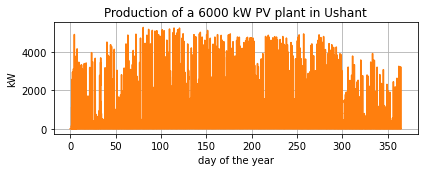

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,2.5))

td = np.arange(len(Pload))/24 # time in days
ax.plot(td, photovoltaic.production(), "C1")

ax.grid(True)
ax.set(
    title=f'Production of a {power_rated_pv:.0f} kW PV plant in Ushant',
    ylabel='kW',
    xlabel='day of the year'
);
fig.tight_layout()
plt.show()

### Microgrid data structure

the `Microgrid` data structure groups:
- project parameters
- load time series
- all components

In [11]:
microgrid = mgs.Microgrid(project, Pload,
    generator, battery,
    {'Solar PV': photovoltaic}
)

Display the microgrid structure and ratings

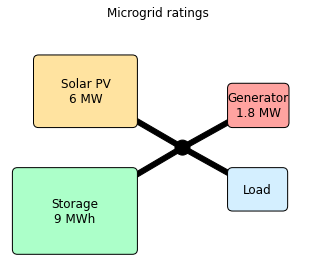

In [12]:
mgs.plotting.plot_ratings(microgrid, 'MW', xlim=(-3.5,2.5), ylim=(-2.5,2.5))
plt.show()

## Simulate the microgrid

Simulation is done in two stages:

1. simulate the **operation**, in particular the energy flow at an hourly timestep between components: 
    - generates operation statistics as `OperationStats` data structure
    - records operation the trajectories of operation variables. Optional since it makes the simulation about 80% slower
2. evaluate the **economic cost** of the project, based on its description and on the operation statistics: 
    - generates cost data as `MicrogridCosts` data structure

### First: Operation simulation (`sim_operation`)

Simulation *without trajectories* (about 2× faster)

In [13]:
oper_stats = mgs.sim_operation(microgrid)

In [14]:
%timeit mgs.sim_operation(microgrid) # 112 ms in JupyterLite, 25 ms with regular Jupyter/Python kernel

33 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Simulation *with trajectories*

In [15]:
oper_traj = mgs.TrajRecorder()
oper_stats = mgs.sim_operation(microgrid, oper_traj)

In [16]:
%timeit mgs.sim_operation(microgrid, oper_traj) # 190 ms in JupyterLite, 41 ms with regular Jupyter/Python kernel

55.7 ms ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Second: Economic evaluation (`sim_economics`)

In [19]:
mg_costs = mgs.sim_economics(microgrid, oper_stats)

In [20]:
%timeit mgs.sim_economics(microgrid, oper_stats) # 140 µs in JupyterLite, 34 µs with regular Jupyter/Python kernel

46.7 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Analyze Microgrid simulation results

### Technical performance

Operation statistics are in `oper_stats` (`OperationStats` data structure)

In [21]:
print(f'Load shedding rate: {oper_stats.shed_rate:.1%}')
print(f'Renewable rate: {oper_stats.renew_rate:.1%}')

Load shedding rate: 0.0%
Renewable rate: 58.7%


The energy mix found in `oper_stats` can be displayed graphically:

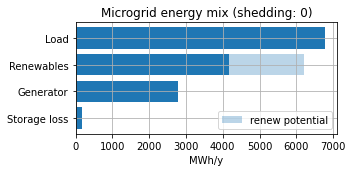

In [22]:
mgs.plotting.plot_energy_mix(microgrid, oper_stats)
plt.show()

### Economic performance

economic performance in `mg_costs` (`MicrogridCosts` data structure)

In [23]:
print(f'Levelized Cost of Electricity: {mg_costs.lcoe:.3f} $/kWh')
print(f'Net Present Cost: {mg_costs.npc/1e6:.2f} M$ (over {project.lifetime} years at {project.discount_rate:.0%} discount rate)')

Levelized Cost of Electricity: 0.297 $/kWh
Net Present Cost: 28.35 M$ (over 25 years at 5% discount rate)


The costs for all components and for all factors can be display in one compact table with `costs_table`. The lower left corner is the Net Present Cost.

In [24]:
cmat, cmat_rows, cmat_cols = mg_costs.costs_table()
print(f'Cost matrix. columns: {cmat_cols}')
print(f'  rows: {cmat_rows}')
print(np.round(cmat/1e6, 3)) # in M$

Cost matrix. columns: ['Investment', 'Replacement', 'O&M', 'Fuel', 'Salvage', 'Total by component']
  rows: ['Generator', 'Storage', 'Solar PV', 'All components']
[[ 0.72   1.952  1.688  9.455 -0.097 13.719]
 [ 3.15   1.564  1.268  0.    -0.24   5.743]
 [ 7.2    0.     1.691  0.    -0.     8.891]
 [11.07   3.516  4.648  9.455 -0.336 28.353]]


### Display operation trajectories


Zoom to first week of January: few solar, battery often empty

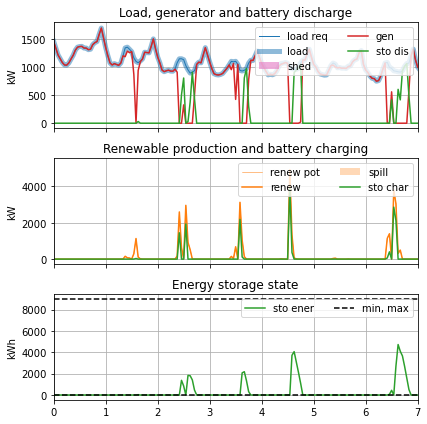

In [25]:
mgs.plotting.plot_oper_traj(microgrid, oper_traj)
plt.xlim(0,7) # 
plt.show()

Zoom to one week in summer: much solar → battery often full → spillage

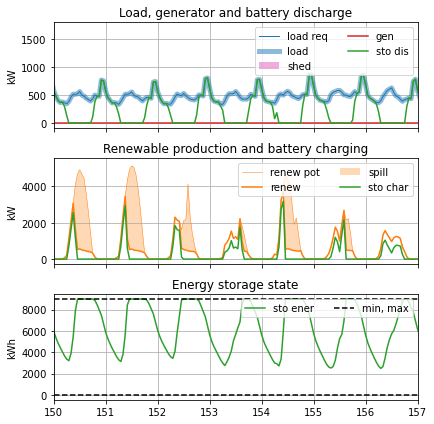

In [26]:
mgs.plotting.plot_oper_traj(microgrid, oper_traj)
plt.xlim(150,157) 
plt.show()

## Interactive simulation displays

Witness the effect of changing the power of the PV plant and the generator and battery energy capacity
*(needs [ipywidgets](https://ipywidgets.readthedocs.io))*.

In [27]:
from ipywidgets import interactive, fixed

### Interactive energy mix

In [32]:
def interactive_mg(power_rated_gen, power_rated_pv, energy_rated_sto):
    """Create Microgrid which includes Generator,
    PV plant and Battery with given ratings"""
    generator = mgs.DispatchableGenerator(power_rated_gen,
        fuel_intercept, fuel_slope, fuel_price,
        investment_price_gen, om_price_gen,
        lifetime_gen
    )
    
    battery = mgs.Battery(energy_rated_sto,
        investment_price_sto, om_price_sto,
        lifetime_sto, lifetime_cycles,
        charge_rate_max, discharge_rate_max,
        loss_factor_sto)
    
    photovoltaic = mgs.Photovoltaic(power_rated_pv, irradiance,
        investment_price_pv, om_price_pv,
        lifetime_pv, derating_factor_pv)
    
    microgrid = mgs.Microgrid(project, Pload,
        generator, battery,
        {'Solar PV': photovoltaic}
    )
    return microgrid

from functools import lru_cache

@lru_cache(maxsize=1000)
def cached_oper_costs(power_rated_gen, power_rated_pv, energy_rated_sto):
    microgrid = interactive_mg(power_rated_gen, power_rated_pv, energy_rated_sto)
    oper_stats = mgs.sim_operation(microgrid)
    mg_costs = mgs.sim_economics(microgrid, oper_stats)
    return oper_stats, mg_costs

def interactive_energy_mix(PV_power=0., Batt_energy=0.):
    """display energy mix with given ratings"""
    microgrid = interactive_mg(power_rated_gen, PV_power, Batt_energy)
    # Simulate
    oper_stats, mg_costs = cached_oper_costs(power_rated_gen, PV_power, Batt_energy)
    # Show some performance stats:
    print(f'Load shedding rate: {oper_stats.shed_rate:.1%}')
    print(f'Renewable rate: {oper_stats.renew_rate:.1%}')
    print(f'Levelized Cost of Electricity: {mg_costs.lcoe:.3f} $/kWh')
    
    # Display energy mix
    fig, (ax1, ax2) = plt.subplots(2,1, num=1, figsize=(6,6),
                                  gridspec_kw=dict(height_ratios=(2,1)))
    mgs.plotting.plot_ratings(microgrid, xlim=(-3.5,2.5), ylim=(-2.5,2.5), ax=ax1)
    mgs.plotting.plot_energy_mix(microgrid, oper_stats, ax=ax2)
    fig.tight_layout()
    plt.show()

Experiment starting from zero PV and zero battery:

1. Start by first increasing PV power
    - at first this reduce the usage of the generator
    - but beyond ~2000 kW, there is more and more spilled energy
2. Then, for a PV power of 5000 kW, increase battery energy to reduce spilled energy
    - at first, this reduces spilled energy and therefore reduces further generator usage
    - but beyond ~8000 kWh, it requires a higher and higher capacity to get an effect

With appropriate settings, you should find a Levelized Cost of Electricity below 0.30 \\$/kWh (while it is 0.35 \\$/kWh without PV and battery).

In [34]:
interactive(interactive_energy_mix, PV_power=(0.0, 10e3, 500), Batt_energy=(0.0, 15e3, 1e3))

interactive(children=(FloatSlider(value=0.0, description='PV_power', max=10000.0, step=500.0), FloatSlider(val…

### Interactive trajectories

Experiment starting from undersize generator, zero PV and zero battery:
- see how increasing the generator power can easily increase the quality of service
  (reduce load shedding, in pink)
- by using a slightly undersized generator (1500 kW), you can still get 0 load shedding
  thanks to PV and battery. And now the cost of electricity can be even a bit smaller (0.28 $/kWh) than with a full size generator (1800 kW).

In [36]:
def interactive_trajectories(Gen_power = 500., PV_power=0., Batt_energy=0., t_plot=60):
    """display trajectories with given ratings, zoomed at `t_plot`"""
    microgrid = interactive_mg(Gen_power, PV_power, Batt_energy)
    # Simulate with trajectory recording
    oper_traj = mgs.TrajRecorder()
    oper_stats = mgs.sim_operation(microgrid, oper_traj)
    mg_costs = mgs.sim_economics(microgrid, oper_stats)
    # Show some performance stats:
    print(f'Load shedding rate: {oper_stats.shed_rate:.1%}')
    print(f'Renewable rate: {oper_stats.renew_rate:.1%}')
    print(f'Levelized Cost of Electricity: {mg_costs.lcoe:.3f} $/kWh')
    # Display trajectories
    mgs.plotting.plot_oper_traj(microgrid, oper_traj)
    plt.xlim(t_plot, t_plot+7)
    plt.show()

interactive(interactive_trajectories, Gen_power = (0.0, 2e3, 100),
            PV_power=(0.0, 10e3, 500), Batt_energy=(0.0, 15e3, 1e3), t_plot=(0.0, 365.-7, 1))

interactive(children=(FloatSlider(value=500.0, description='Gen_power', max=2000.0, step=100.0), FloatSlider(v…